In [1]:
import pandas as pd
import numpy as np
import cleaner
import re
import torch
import nltk
import contractions

from tqdm.notebook import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModel
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords_en = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

bert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
bert_model = AutoModel.from_pretrained("microsoft/codebert-base")


import spacy

nlp = spacy.load('en_core_web_lg')

tqdm.pandas()

[nltk_data] Downloading package stopwords to /home/ae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ae/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
TARGET = [
    'C', 'C#', 'C++', 'Dart', 'Elixir', 'Go', 'JSON', 'Java', 
    'Javascript', 'Julia', 'Kotlin', 'Markdown', 'Ruby', 'Rust', 'Python'
]

In [37]:
def clean_comments(contents, language) -> str:
    delimiters = cleaner.lang(language)

    if delimiters is not None:
        contents = cleaner.string(contents, *delimiters)

    return contents

def clean_extras(contents) -> str:
    contents = re.sub(r"[\r]", "", contents)
    contents = re.sub(r"'[^']*'", "''", contents)
    contents = re.sub('"[^"]*"', '""', contents)
    contents = re.sub(r"\w{15,}", "", contents)
    contents = re.sub("[\n]{2,}", "\n", contents)
    contents = re.sub("[\t]{2,}", "\t", contents)
    contents = re.sub(r"[ ]+", " ", contents)

    contents = "\n".join(
        [line for line in contents.splitlines() if len(line.strip()) != 0]
    )

    return contents

def tokenize_bert(source: str):
    tokens = bert_tokenizer.tokenize(
        source, return_tensors="pt", truncation=True, max_length=512
    )
    lemmas = [
        lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en
    ]
    return bert_tokenizer.convert_tokens_to_ids(lemmas)


def vectorize_bert(tokens) -> np.ndarray:
    with torch.no_grad():
        outputs = bert_model(torch.tensor(tokens)[None, :])

    # We use the [CLS] token's embedding as the representation of the entire code snippet
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

    return cls_embedding


def vectorize_spacy(texto: str) -> np.ndarray:
    texto = texto.lower()
    texto = contractions.fix(texto)
    texto = re.sub(r'[^A-Za-z\s]', '', texto)
    tokens = word_tokenize(texto)
    
    # Porque queremos encontrar las palabras en el diccionario no usamos stemming
    lemmas = (lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en)
    
    resultado = " ".join(lemmas)
    vector = nlp(resultado[:1000000]).vector
    return vector

## CodeBERT

In [38]:
df = pd.concat([
	pd.read_pickle('../scripts/bert_clean_3000x512_aprox_0'),
	pd.read_pickle('../scripts/bert_clean_3000x512_aprox_1'),
	pd.read_pickle('../scripts/bert_clean_3000x512_aprox_2'),
	pd.read_pickle('../scripts/bert_clean_3000x512_aprox_3'),
	pd.read_pickle('../scripts/bert_clean_3000x512_aprox_4'),
	pd.read_pickle('../scripts/bert_clean_3000x512_aprox_5'),
	pd.read_pickle('../scripts/bert_clean_3000x512_aprox_6'),
	pd.read_pickle('../scripts/bert_clean_3000x512_aprox_7'),
	pd.read_pickle('../scripts/bert_clean_3000x512_aprox_8'),
	pd.read_pickle('../scripts/bert_clean_3000x512_aprox_9'),
])

In [39]:
len(df)

40042

In [40]:
list(df)

['language', 'source', 'tokens', 'vector']

<Axes: xlabel='language'>

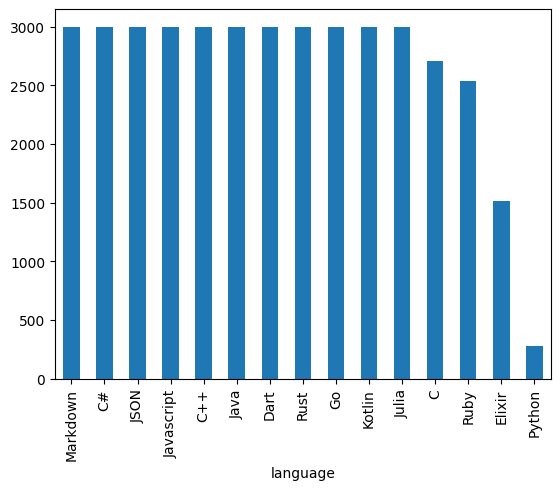

In [41]:
df['language'].value_counts().plot(kind = "bar")

In [42]:
mapper = {}
for i in range(len(TARGET)):
    mapper[TARGET[i]] = i

df['lang'] = df['language'].map(mapper)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

X = df['vector']
# X = np.concatenate(X, axis=0).reshape(-1, 300)
X = np.vstack(X).reshape(-1, 768)
y = df['lang']

#stratify se asegura de mantener una proporcion entre las clases
X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.9, random_state=101, stratify=y)

In [44]:
from tensorflow.keras import Sequential, layers, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

early_stopping = callbacks.EarlyStopping(
    monitor = 'val_loss',
    restore_best_weights = True,
    patience = 3
)

In [45]:
y_train = to_categorical(y_train, len(TARGET))
y_test = to_categorical(y_test, len(TARGET))

In [46]:
model = Sequential()

# 300 neuronas de entrada conectadas todas con todas con 128
# model.add(layers.Input((300))
model.add(layers.Dense(units=768, activation='relu', input_dim=768))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=768, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=768, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(units=768, activation='relu'))
model.add(layers.Dropout(0.3))
# 3 de salida porque son 3 categoria
model.add(layers.Dense(len(TARGET), activation="softmax"))

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

model.summary()

/home/ae/repos/proyecto-pln/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 15)             │        11,535 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,373,903 (9.06 MB)

 Trainable params: 2,373,903 (9.06 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model.fit(
    X_train, y_train,
    batch_size=50,
    epochs=1000,
    callbacks = [early_stopping],
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.0816 - loss: 2.7864 - val_accuracy: 0.3336 - val_loss: 2.5403
Epoch 2/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1583 - loss: 2.5560 - val_accuracy: 0.4607 - val_loss: 2.0721
Epoch 3/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3300 - loss: 2.1097 - val_accuracy: 0.5919 - val_loss: 1.4078
Epoch 4/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4751 - loss: 1.5628 - val_accuracy: 0.7264 - val_loss: 1.0232
Epoch 5/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5625 - loss: 1.2038 - val_accuracy: 0.7955 - val_loss: 0.7795
Epoch 6/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6417 - loss: 0.9883 - val_accuracy: 0.8071 - val_loss: 0.6513
Epoch 7/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7216 - loss: 0.8242 - val_accuracy: 0.8449 - val_loss: 0.5232
Epoch 8/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7756 - loss: 0.6810 - val_accu

<Axes: >

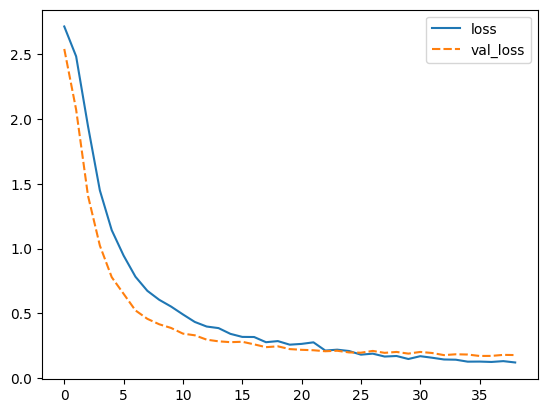

In [48]:
metrics = pd.DataFrame(history.history)
sns.lineplot(data=metrics[['loss', 'val_loss']])

<Axes: >

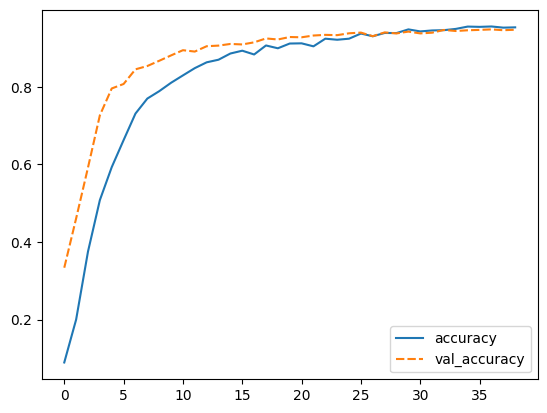

In [49]:
metrics = pd.DataFrame(history.history)
sns.lineplot(data=metrics[['accuracy', 'val_accuracy']])

In [50]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_true = np.argmax(y_test, axis =-1)

1127/1127 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [51]:
print(classification_report(y_true, y_pred, target_names=TARGET))

              precision    recall  f1-score   support

           C       0.80      0.88      0.83      2433
          C#       0.98      0.98      0.98      2700
         C++       0.89      0.77      0.82      2700
        Dart       0.94      0.92      0.93      2700
      Elixir       0.93      0.97      0.95      1363
          Go       0.99      0.99      0.99      2700
        JSON       0.98      1.00      0.99      2700
        Java       0.94      0.99      0.96      2700
  Javascript       0.94      0.96      0.95      2700
       Julia       0.96      0.95      0.95      2700
      Kotlin       0.99      0.99      0.99      2700
    Markdown       0.98      0.95      0.96      2700
        Ruby       0.98      0.97      0.98      2287
        Rust       0.96      0.96      0.96      2700
      Python       0.98      0.82      0.90       254

    accuracy                           0.95     36037
   macro avg       0.95      0.94      0.94     36037
weighted avg       0.95   

<Axes: >

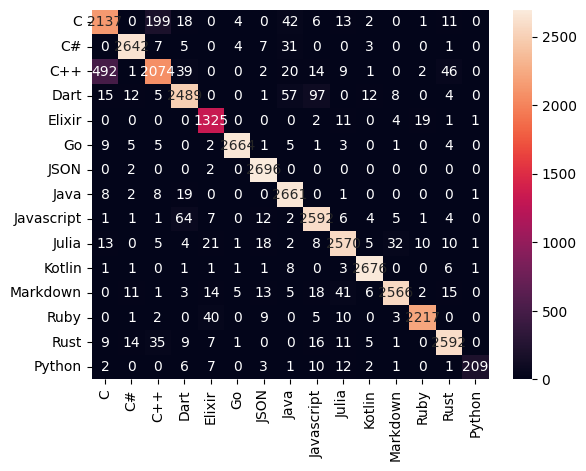

In [52]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='.0f', xticklabels=TARGET, yticklabels=TARGET)

In [53]:
model.save('fnn_bert.keras')

In [54]:
import plotly.express as px

fig = px.imshow(confusion_matrix(y_true, y_pred), text_auto=True, template="plotly_dark", aspect="auto", x=TARGET, y=TARGET, color_continuous_scale='RdBu_r',)

with open("../resources/fnn_matrix_bert.json", "w") as spcy:
    spcy.write(fig.to_json())

fig.show()

In [1]:
def predecir(source, verbose = False, multi = [], single = []):
    
    cleaned = clean_extras(ccleaner.clean_string(source, multi, single), "")
    vec = vectorize(tokenize(cleaned)).reshape(1,-1)
    resultado = model.predict(vec, verbose = 0)

    if verbose:
        for i in range(len(TARGET)):
            print(f'{TARGET[i]: >10}: {round(resultado[0][i] * 100, 2): <2.2f} %')
    
    return TARGET[np.argmax(resultado)]

## spaCy Cleaned

In [55]:
df = pd.read_pickle('../scripts/clean_chunks_no_str_spacy')

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

X = df['vector']
# X = np.concatenate(X, axis=0).reshape(-1, 300)
X = np.vstack(X).reshape(-1, 300)
y = df['lang']

#stratify se asegura de mantener una proporcion entre las clases
X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.9, random_state=101, stratify=y)

In [57]:
from tensorflow.keras import Sequential, layers, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

early_stopping = callbacks.EarlyStopping(
    monitor = 'val_loss',
    restore_best_weights = True,
    patience = 3
)

In [58]:
y_train = to_categorical(y_train, len(TARGET))
y_test = to_categorical(y_test, len(TARGET))

In [59]:
model = Sequential()

# 300 neuronas de entrada conectadas todas con todas con 128
# model.add(layers.Input((300))
model.add(layers.Dense(units=300, activation='relu', input_dim=300))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=300, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=300, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(units=300, activation='relu'))
model.add(layers.Dropout(0.3))
# 3 de salida porque son 3 categoria
model.add(layers.Dense(len(TARGET), activation="softmax"))

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

model.summary()

/home/ae/repos/proyecto-pln/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 15)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,715 (1.40 MB)

 Trainable params: 365,715 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
history = model.fit(
    X_train, y_train,
    batch_size=50,
    epochs=1000,
    callbacks = [early_stopping],
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.0830 - loss: 2.9286 - val_accuracy: 0.3886 - val_loss: 2.4763
Epoch 2/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1635 - loss: 2.5915 - val_accuracy: 0.4676 - val_loss: 2.3045
Epoch 3/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2243 - loss: 2.4288 - val_accuracy: 0.5280 - val_loss: 2.0704
Epoch 4/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3191 - loss: 2.2267 - val_accuracy: 0.5857 - val_loss: 1.7810
Epoch 5/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3838 - loss: 2.0441 - val_accuracy: 0.6030 - val_loss: 1.5462
Epoch 6/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4331 - loss: 1.8433 - val_accuracy: 0.6415 - val_loss: 1.3693
Epoch 7/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4831 - loss: 1.6935 - val_accuracy: 0.6709 - val_loss: 1.2329
Epoch 8/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5287 - loss: 1.5489 - val_accu

<Axes: >

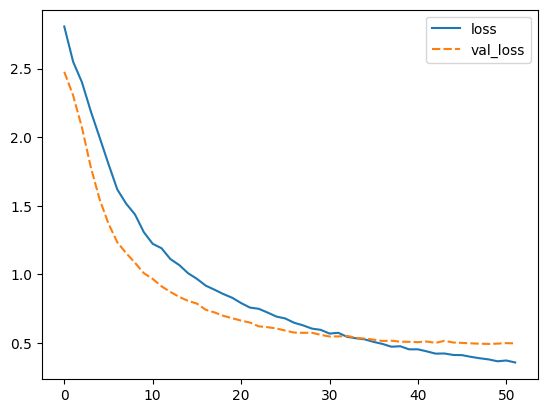

In [61]:
metrics = pd.DataFrame(history.history)
sns.lineplot(data=metrics[['loss', 'val_loss']])

<Axes: >

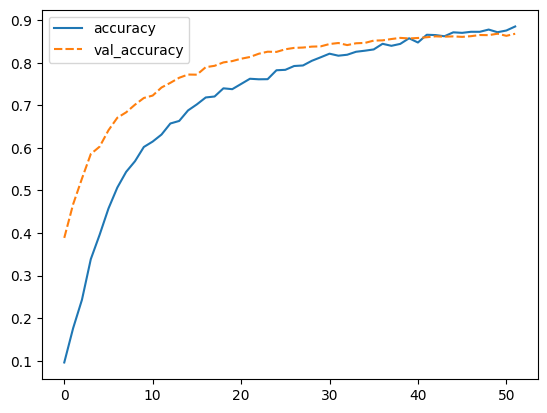

In [62]:
metrics = pd.DataFrame(history.history)
sns.lineplot(data=metrics[['accuracy', 'val_accuracy']])

In [63]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_true = np.argmax(y_test, axis =-1)

1127/1127 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [64]:
print(classification_report(y_true, y_pred, target_names=TARGET))

              precision    recall  f1-score   support

           C       0.60      0.80      0.68      2433
          C#       0.96      0.98      0.97      2700
         C++       0.76      0.46      0.57      2700
        Dart       0.89      0.92      0.91      2700
      Elixir       0.83      0.78      0.80      1363
          Go       0.92      0.84      0.88      2700
        JSON       0.81      0.98      0.89      2700
        Java       0.91      0.94      0.92      2700
  Javascript       0.86      0.84      0.85      2700
       Julia       0.91      0.89      0.90      2700
      Kotlin       0.93      0.97      0.95      2700
    Markdown       0.90      0.90      0.90      2700
        Ruby       0.89      0.90      0.90      2287
        Rust       0.95      0.95      0.95      2700
      Python       0.94      0.06      0.12       254

    accuracy                           0.86     36037
   macro avg       0.87      0.81      0.81     36037
weighted avg       0.87   

<Axes: >

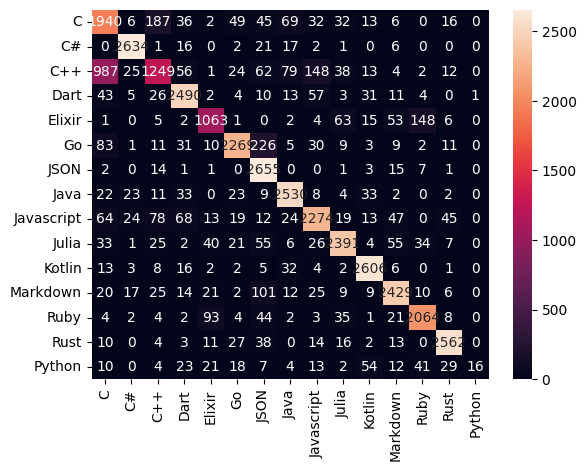

In [65]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='.0f', xticklabels=TARGET, yticklabels=TARGET)

In [66]:
model.save('fnn_spacy.keras')

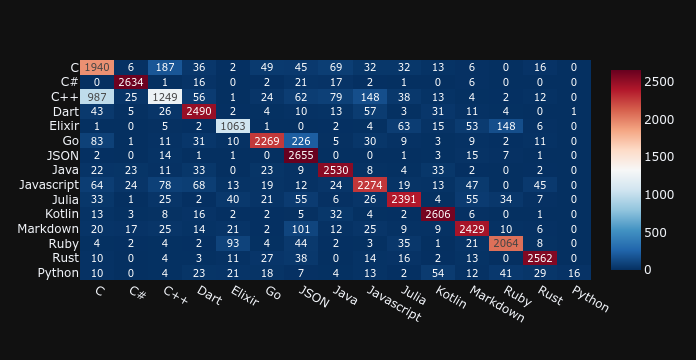

In [67]:
import plotly.express as px

fig = px.imshow(confusion_matrix(y_true, y_pred), text_auto=True, template="plotly_dark", aspect="auto", x=TARGET, y=TARGET, color_continuous_scale='RdBu_r',)

with open("../resources/fnn_matrix_spacy_clean.json", "w") as spcy:
    spcy.write(fig.to_json())

fig.show()

## Spacy Dirty

In [41]:
df = pd.read_pickle('../scripts/dirty_chunks_no_str_dirty')

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

X = df['vector']
# X = np.concatenate(X, axis=0).reshape(-1, 300)
X = np.vstack(X).reshape(-1, 300)
y = df['lang']

#stratify se asegura de mantener una proporcion entre las clases
X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.9, random_state=101, stratify=y)

In [43]:
from tensorflow.keras import Sequential, layers, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

early_stopping = callbacks.EarlyStopping(
    monitor = 'val_loss',
    restore_best_weights = True,
    patience = 3
)

In [44]:
y_train = to_categorical(y_train, len(TARGET))
y_test = to_categorical(y_test, len(TARGET))

In [47]:
model = Sequential()

# 300 neuronas de entrada conectadas todas con todas con 128
# model.add(layers.Input((300))
model.add(layers.Dense(units=300, activation='relu', input_dim=300))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=300, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=300, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(units=300, activation='relu'))
model.add(layers.Dropout(0.3))
# 3 de salida porque son 3 categoria
model.add(layers.Dense(len(TARGET), activation="softmax"))

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 15)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,715 (1.40 MB)

 Trainable params: 365,715 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history = model.fit(
    X_train, y_train,
    batch_size=50,
    epochs=1000,
    callbacks = [early_stopping],
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0944 - loss: 2.9563 - val_accuracy: 0.3284 - val_loss: 2.4699
Epoch 2/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1654 - loss: 2.5766 - val_accuracy: 0.3911 - val_loss: 2.3212
Epoch 3/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2018 - loss: 2.4412 - val_accuracy: 0.4498 - val_loss: 2.1562
Epoch 4/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2590 - loss: 2.3245 - val_accuracy: 0.4787 - val_loss: 1.9696
Epoch 5/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3169 - loss: 2.1458 - val_accuracy: 0.5449 - val_loss: 1.7902
Epoch 6/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3781 - loss: 2.0132 - val_accuracy: 0.5679 - val_loss: 1.6199
Epoch 7/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4237 - loss: 1.8630 - val_accuracy: 0.5935 - val_loss: 1.4920
Epoch 8/1000
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4470 - loss: 1.7625 - val_accu

<Axes: >

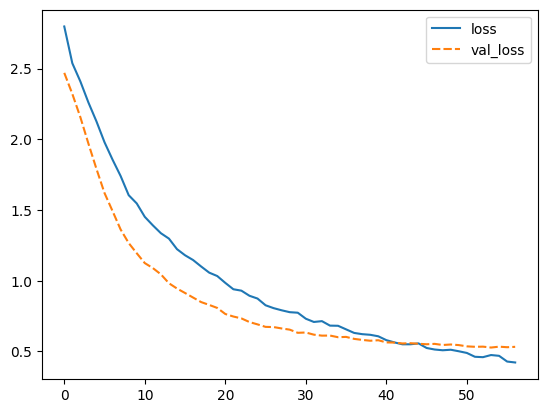

In [49]:
metrics = pd.DataFrame(history.history)
sns.lineplot(data=metrics[['loss', 'val_loss']])

<Axes: >

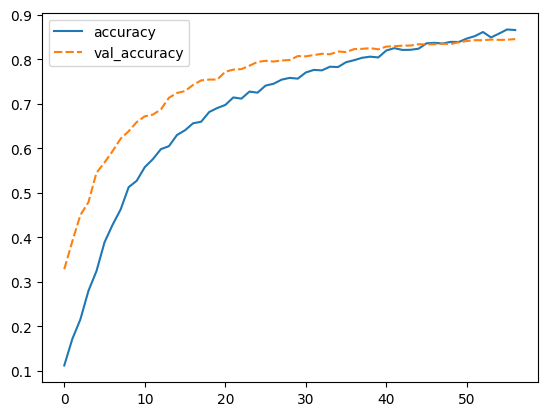

In [50]:
metrics = pd.DataFrame(history.history)
sns.lineplot(data=metrics[['accuracy', 'val_accuracy']])

In [51]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_true = np.argmax(y_test, axis =-1)

1134/1134 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step


In [52]:
print(classification_report(y_true, y_pred, target_names=TARGET))

              precision    recall  f1-score   support

           C       0.56      0.56      0.56      2148
          C#       0.96      0.97      0.97      2700
         C++       0.62      0.58      0.60      2700
        Dart       0.88      0.86      0.87      2700
      Elixir       0.89      0.78      0.83      1483
          Go       0.90      0.87      0.89      2700
        JSON       0.83      0.96      0.89      2700
        Java       0.89      0.88      0.89      2700
  Javascript       0.83      0.88      0.85      2700
       Julia       0.88      0.88      0.88      2700
      Kotlin       0.93      0.97      0.95      2700
    Markdown       0.81      0.78      0.80      2700
        Ruby       0.88      0.90      0.89      2700
        Rust       0.89      0.92      0.91      2700
      Python       0.95      0.15      0.26       257

    accuracy                           0.84     36288
   macro avg       0.85      0.80      0.80     36288
weighted avg       0.84   

<Axes: >

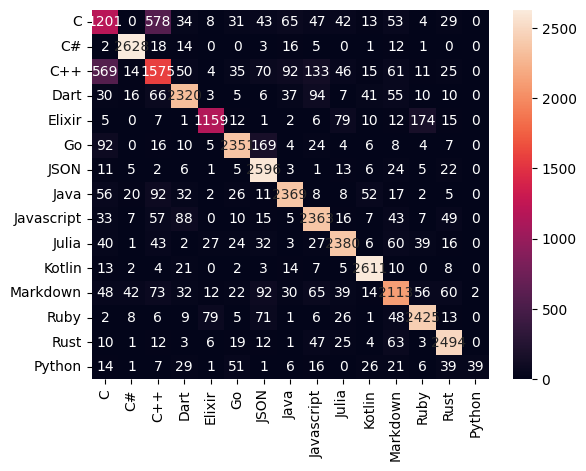

In [53]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='.0f', xticklabels=TARGET, yticklabels=TARGET)